In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import nltk
import spacy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
% matplotlib inline
from spacy.lang.en import English
nlp = English()

In [ ]:
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///tweets_global 2.db') # parsing the data
df = pd.read_sql('SELECT * FROM verified', disk_engine) 
df1 = pd.read_sql('SELECT * FROM Twitter', disk_engine)

In [ ]:
df.firmName.value_counts()

In [59]:
df.head()

,index,favoriteCount,firmName,id,isPinned,isReplyTo,isRetweet,replyCount,retweetCount,screenName,text,time,date,time_new,cleaned_text,Sentiment_score,verified
0,0,9,BAE,885287603020410881,0,0,0,0,6,gangstagvbs,Lemme scratch yo head in bed and tell me bout ...,2017-07-12T23:59:47.000Z,2017-07-12,23:59:47,lemme scratch yo head in bed and tell me bout ...,0.0000,0
1,1,31,BAE,885285743278641154,0,0,0,1,2,SydneyJeanne22,when bae wants to do things with you ❣️,2017-07-12T23:52:23.000Z,2017-07-12,23:52:23,when bae wants to do things with you ❣️,0.0000,0
2,2,19,BAE,885284885035876352,0,0,0,0,0,HYPED0LANS,cute bae being cute as usual,2017-07-12T23:48:59.000Z,2017-07-12,23:48:59,cute bae being cute as usual,0.7184,0
3,3,307,BAE,885284412769710085,0,0,0,16,19,lilkymchii,When you just tryna look good for bae 😈💖😎🙃,2017-07-12T23:47:06.000Z,2017-07-12,23:47:06,when you just tryna look good for bae,0.4404,0
4,4,711,BAE,885283703899009024,0,0,0,8,236,Dariathatsall,Stream bae. #DespacitoRemix ♫,2017-07-12T23:44:17.000Z,2017-07-12,23:44:17,stream bae despacitoremix ♫,0.0000,0


In [4]:
len(df)

92145

In [5]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
df['date'] = [d.date() for d in df['date']]
df1['date'] = pd.to_datetime(df1['date'], dayfirst=True, errors='coerce')
df1['date'] = [d.date() for d in df1['date']]

In [6]:
df.firmName.value_counts()

BAE           56011
Tata          12480
Bombardier     7159
Polestar       4514
Doosan         3730
SABMiller      3136
Courtaulds     1913
Ethicon        1878
Greencore      1052
Delphi          189
Carron           83
Name: firmName, dtype: int64

In [7]:
df2 = df[df['verified']=='0']

In [8]:
len(df2)

79798

In [14]:
def descr_missing_dates(name, date, df = df):
    
    """function to provide some descriptive statistics, 
    plot the bar chart for the number of tweets per day, their mean including the dates missing 
    in the dataframe firm-vice"""
    
    dfi = df[df['firmName'] == name] #choose the values for the specific firm
    date = pd.to_datetime(date).date()
    dfi["announcement"] = dfi.date.apply(lambda x: 1 if x<=date else 0)#to split data on before and after the very date
    
    #some statistics:
    m = dfi.groupby(dfi['date'])['id'].size().reset_index()
    print("maximum: ")
    print (m.loc[m['id'].idxmax()])
    print("mean: ")
    y_mean = m['id'].mean()
    print(y_mean)
    print("std: ")
    print([m['id'].std()])
   # ax = dfi.groupby(['date'])['id'].count().plot(kind='bar', figsize = (75, 20), 
         #                                                                grid = False, fontsize=20, color = "b", sharex = True)# to plot the results
    a = dfi.groupby(['date'])['id'].count().reset_index()
    a['date'] = pd.to_datetime(a['date'], dayfirst=True, errors='coerce')
    r = pd.date_range(start=a.date.min(), end=a.date.max())
    a = a.set_index('date').reindex(r).fillna(0.0).rename_axis('dt').reset_index() #to add missing dates
    a['dt'] = [d.date() for d in a['dt']]
    ax = a.plot(x = 'dt', y = 'id', kind='bar', figsize = (75, 20), grid = False, fontsize=20, color = "b", sharex = True)# to plot the results
    
    plt.axhline(y=y_mean,color='k', linestyle='dashed', linewidth=5, label='Mean')
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              dfi['announcement'].values[np.newaxis],
            cmap='magma', alpha=0.3)
    ax.set_xlabel("day", fontsize=20)
    ax.set_ylabel("number of tweets " + name, fontsize=20)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


maximum: 
date    2016-04-18
id              16
Name: 3, dtype: object
mean: 
2.3055555555555554
std: 
[3.4294476393598887]


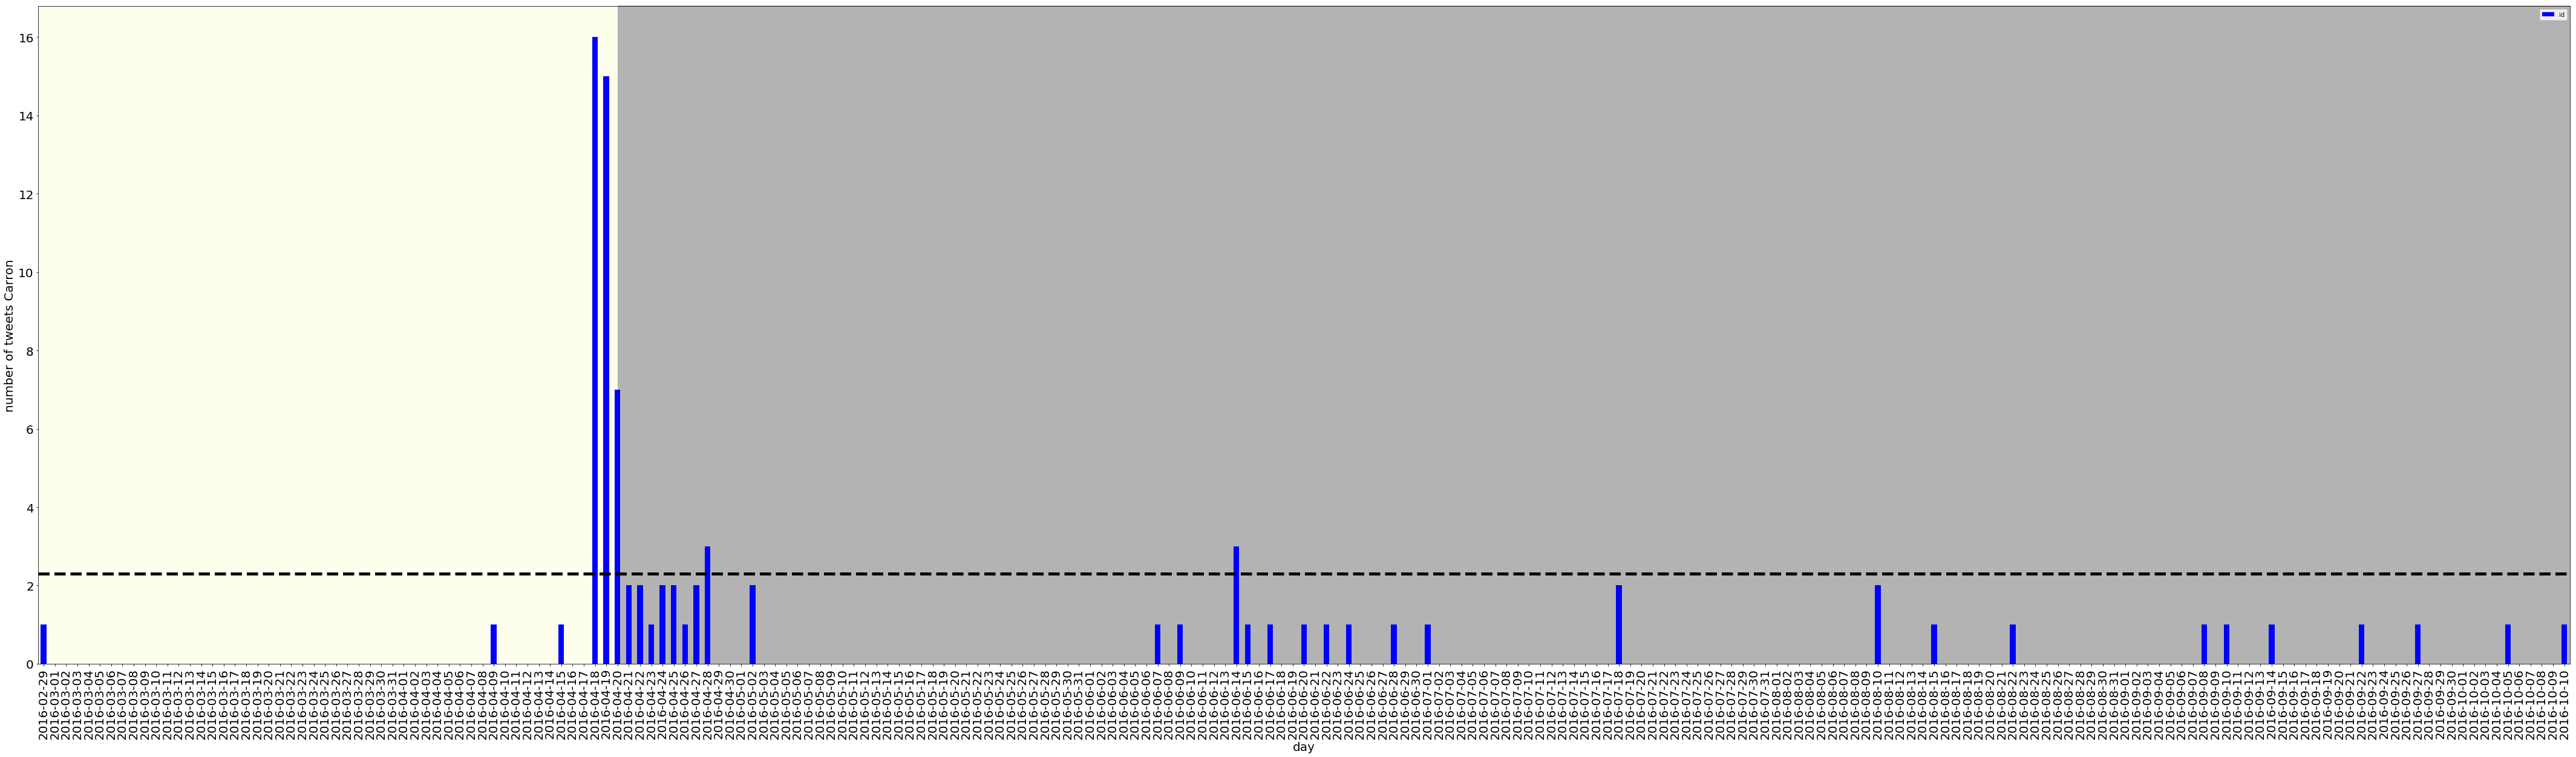

In [15]:
descr_missing_dates("Carron", "2016-04-18")

In [16]:
def descr_user(name, date, df = df):
    
    """function to provide some descriptive statistics, 
    plot the bar chart for the number of unique users per day including the dates missing 
    in the dataframe with all users, firm-vice"""
    
    dfi = df[df['firmName'] == name]
    date = pd.to_datetime(date).date()
    dfi["announcement"] = dfi.date.apply(lambda x: 1 if x<=date else 0)
    print ("mean_per_user: ")
    print(dfi.groupby(['date'])['id'].count().sum()/dfi.groupby(by = ['date']).agg({'screenName': pd.Series.nunique}).sum())
   # ax = dfi.groupby(by = ['date']).agg({'screenName': pd.Series.nunique}).plot(kind='bar', figsize = (65, 15), 
    #                                                                     grid = True, fontsize=20, legend = True, color = "r") # to plot the results
    a = dfi.groupby(by = ['date']).agg({'screenName': pd.Series.nunique}).reset_index()
    a['date'] = pd.to_datetime(a['date'], dayfirst=True, errors='coerce')
    r = pd.date_range(start=a.date.min(), end=a.date.max())
    a = a.set_index('date').reindex(r).fillna(0.0).rename_axis('dt').reset_index()
    a['dt'] = [d.date() for d in a['dt']]
    ax = a.plot(x = 'dt', y = 'screenName', kind='bar', figsize = (75, 20), grid = False, fontsize=20, color = "r", sharex = True)# to plot the results
    
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              dfi['announcement'].values[np.newaxis],
            cmap='magma', alpha=0.3)
    ax.set_xlabel("day")
    ax.set_ylabel("number of users, " +name, fontsize=20)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


mean_per_user: 
screenName    1.0375
dtype: float64


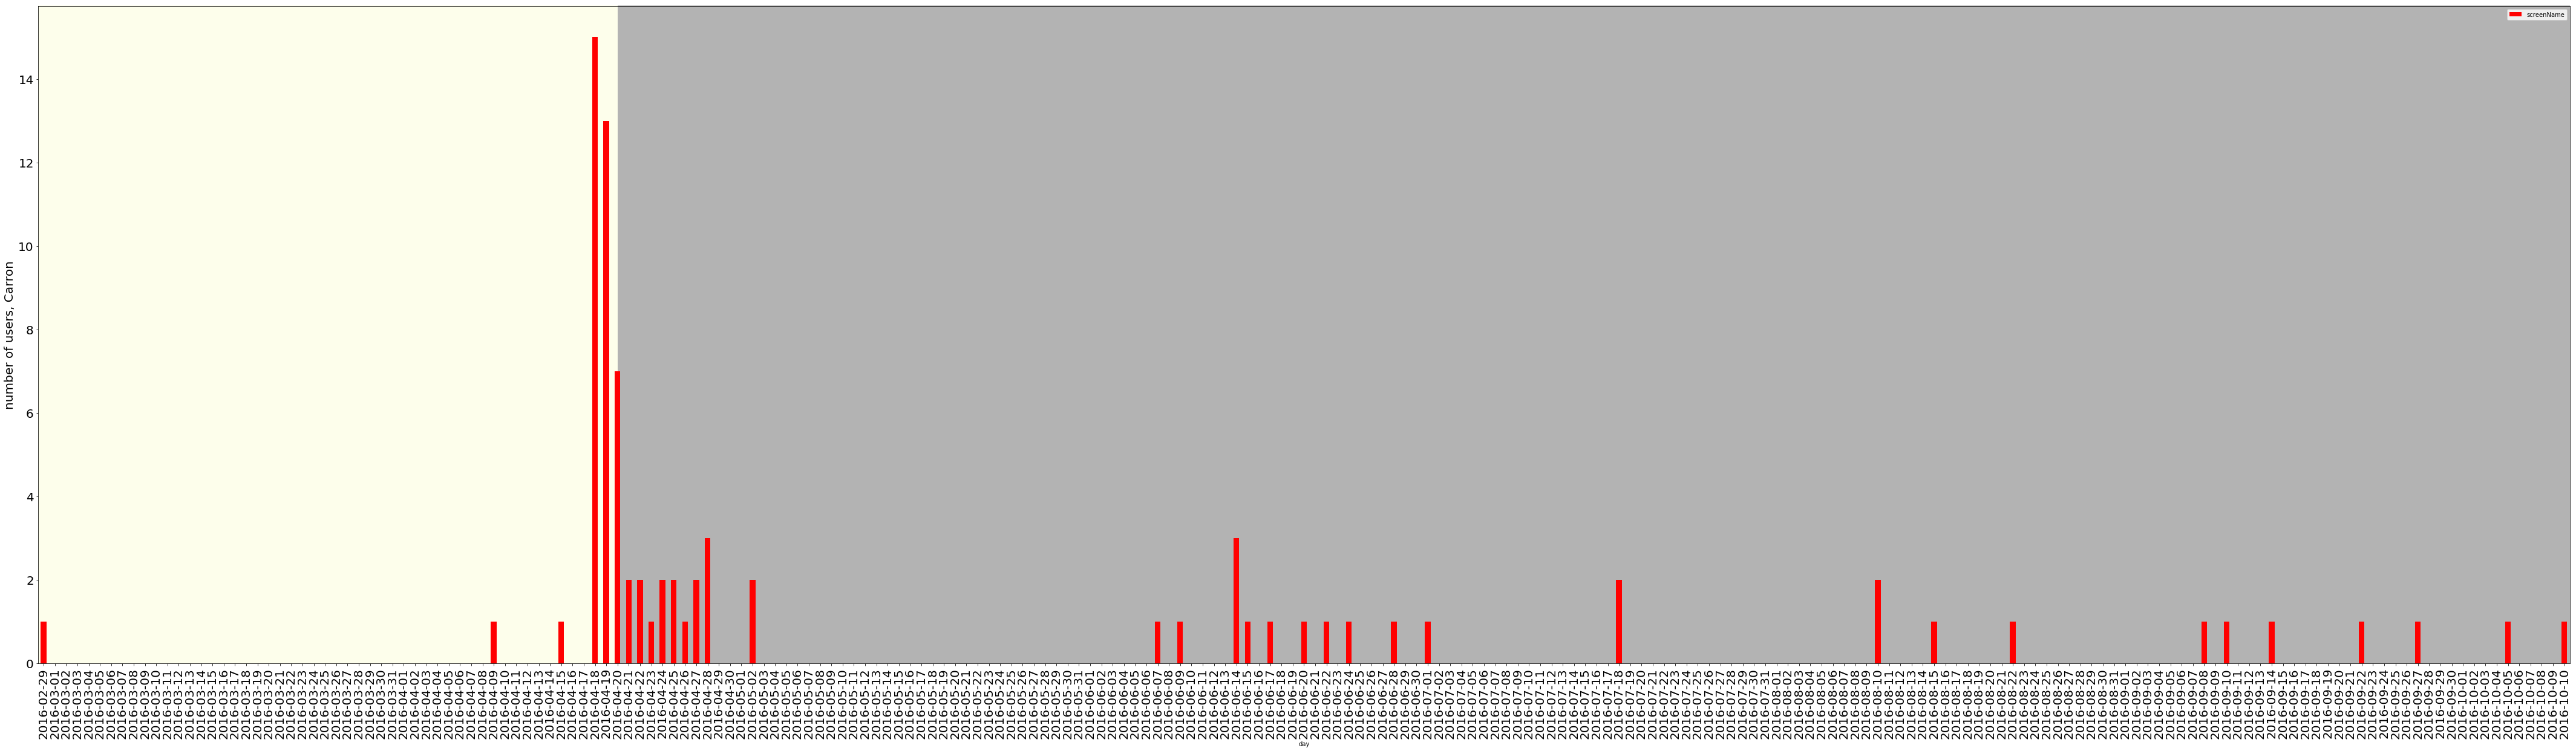

In [17]:
descr_user("Carron", "2016-04-18")

In [18]:
def descr_ver(name, date, df = df2):
    
    """function to provide some descriptive statistics, 
    plot the bar chart for the number of tweets per day, their mean including the dates missing 
    in the dataframe with non-verified users, firm-vice"""
    
    dfi = df[df['firmName'] == name]
    date = pd.to_datetime(date).date()
    dfi["announcement"] = dfi.date.apply(lambda x: 1 if x<=date else 0)
    m = dfi.groupby(dfi['date'])['id'].size().reset_index()
    print("maximum: ")
    print(m.loc[m['id'].idxmax()])
    print("mean: ")
    y_mean = m['id'].mean()
    print([m['id'].mean()])
    print("std: ")
    print([m['id'].std()])
    
    #ax = dfi.groupby(['date'])['id'].count().plot(kind='bar', figsize = (75, 20), 
                                                                         #grid = False, fontsize=20, color = "b", sharex = True)# to plot the results
    
    a = dfi.groupby(['date'])['id'].count().reset_index()
    a['date'] = pd.to_datetime(a['date'], dayfirst=True, errors='coerce')
    r = pd.date_range(start=a.date.min(), end=a.date.max())
    a = a.set_index('date').reindex(r).fillna(0.0).rename_axis('dt').reset_index()
    a['dt'] = [d.date() for d in a['dt']]
    ax = a.plot(x = 'dt', y = 'id', kind='bar', figsize = (75, 20), grid = False, fontsize=20, color = "b", sharex = True)# to plot the results
    
    plt.axhline(y=y_mean,color='k', linestyle='dashed', linewidth=5, label='Mean')
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              dfi['announcement'].values[np.newaxis],
            cmap='magma', alpha=0.3)
    ax.set_xlabel("day", fontsize=20)
    ax.set_ylabel("number of verified tweets " + name, fontsize=20)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


maximum: 
date    2016-04-19
id              10
Name: 4, dtype: object
mean: 
[1.9428571428571428]
std: 
[2.02837021134844]


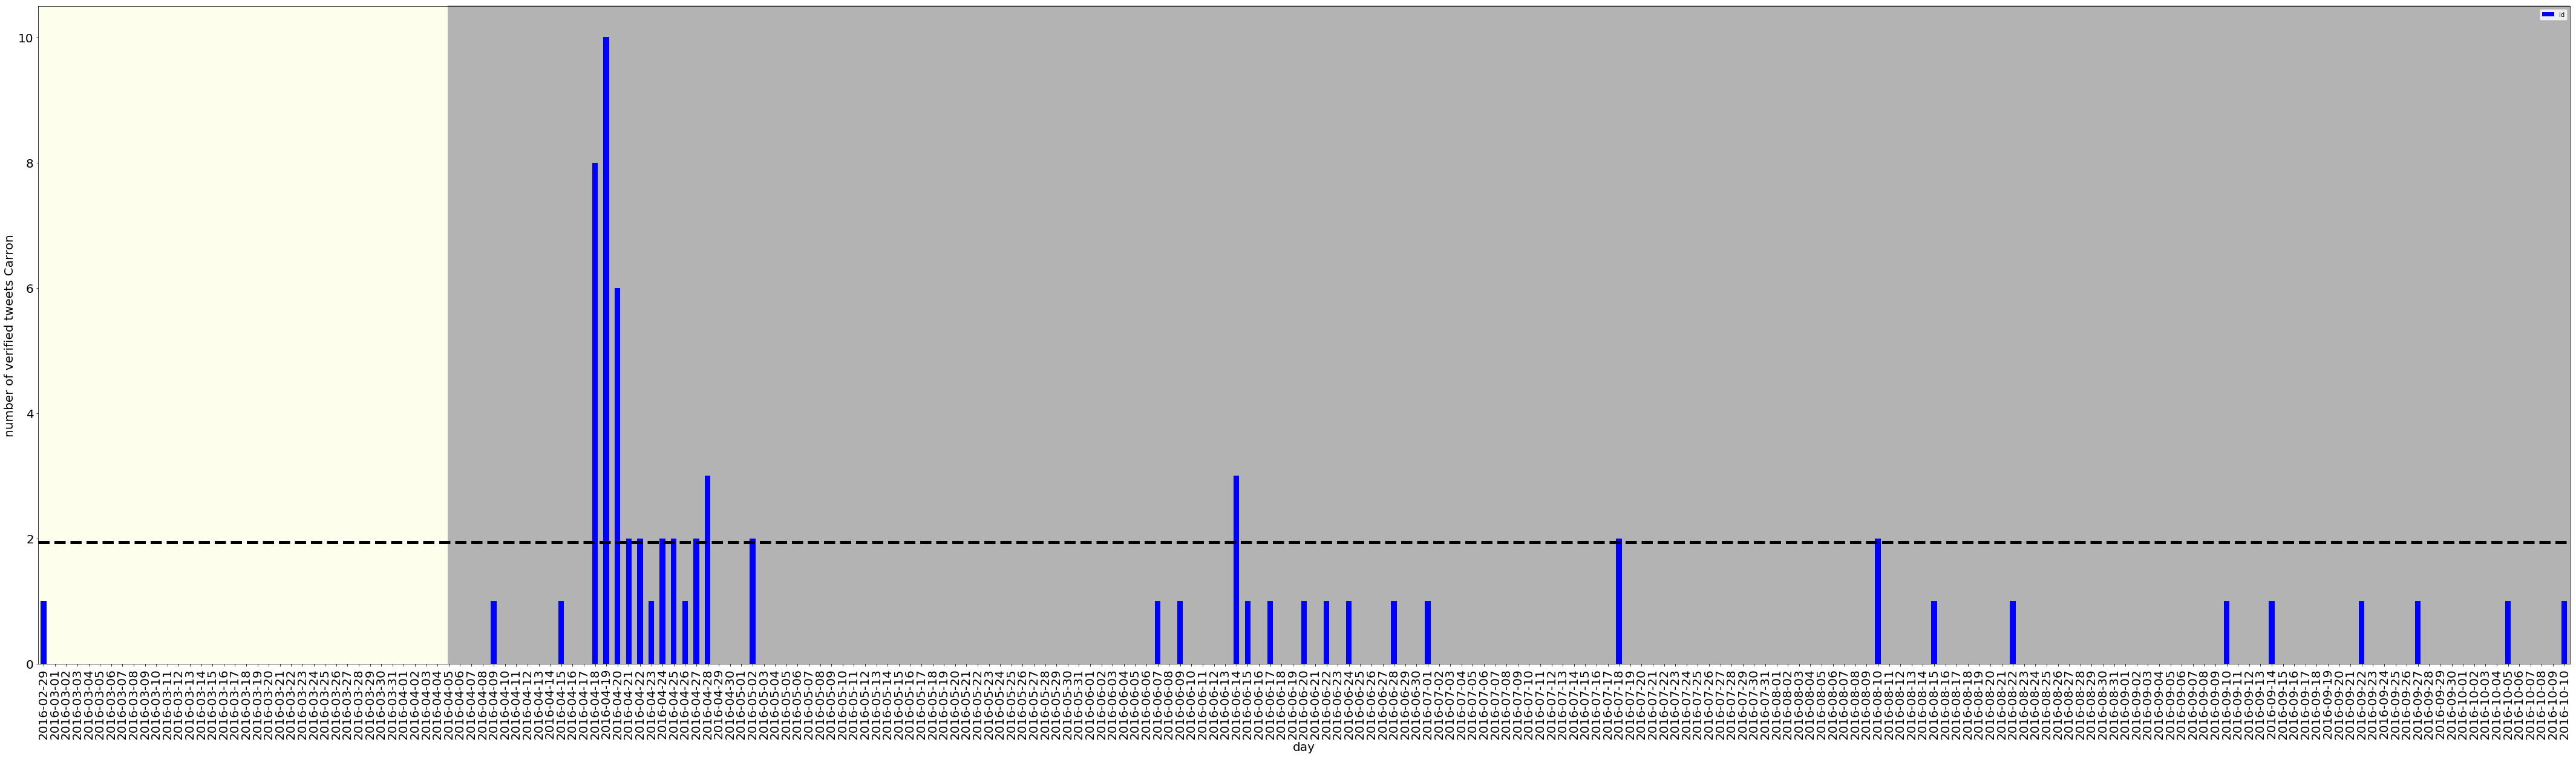

In [19]:
descr_ver("Carron", "2016-04-18")

In [20]:
def descr_user_ver(name, date, df = df2):
    
    """function to provide some descriptive statistics, 
    plot the bar chart for the number of unique users per day including the dates missing 
    in the dataframe with non-verified users, firm-vice"""
    
    dfi = df[df['firmName'] == name]
    date = pd.to_datetime(date).date()
    dfi["announcement"] = dfi.date.apply(lambda x: 1 if x<=date else 0)
    
    #stats on the number of tweets per user:
    print(dfi.groupby(['date'])['id'].count().sum()/dfi.groupby(by = ['date']).agg({'screenName': pd.Series.nunique}).sum())
   
    #ax = dfi.groupby(by = ['date']).agg({'screenName': pd.Series.nunique}).plot(kind='bar', figsize = (65, 15), 
                                                                        # grid = True, fontsize=20, legend = True, color = "r") # to plot the results

    a = dfi.groupby(by = ['date']).agg({'screenName': pd.Series.nunique}).reset_index()
    a['date'] = pd.to_datetime(a['date'], dayfirst=True, errors='coerce')
    r = pd.date_range(start=a.date.min(), end=a.date.max())
    a = a.set_index('date').reindex(r).fillna(0.0).rename_axis('dt').reset_index()
    a['dt'] = [d.date() for d in a['dt']]
    ax = a.plot(x = 'dt', y = 'screenName', kind='bar', figsize = (75, 20), grid = False, fontsize=20, color = "r", sharex = True)# to plot the results
    
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              dfi['announcement'].values[np.newaxis],
            cmap='magma', alpha=0.3)
    #ax.title = 'Tweet user counts by day'
    ax.set_xlabel("day")
    ax.set_ylabel("number of verified users, " +name, fontsize=20)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


screenName    1.030303
dtype: float64


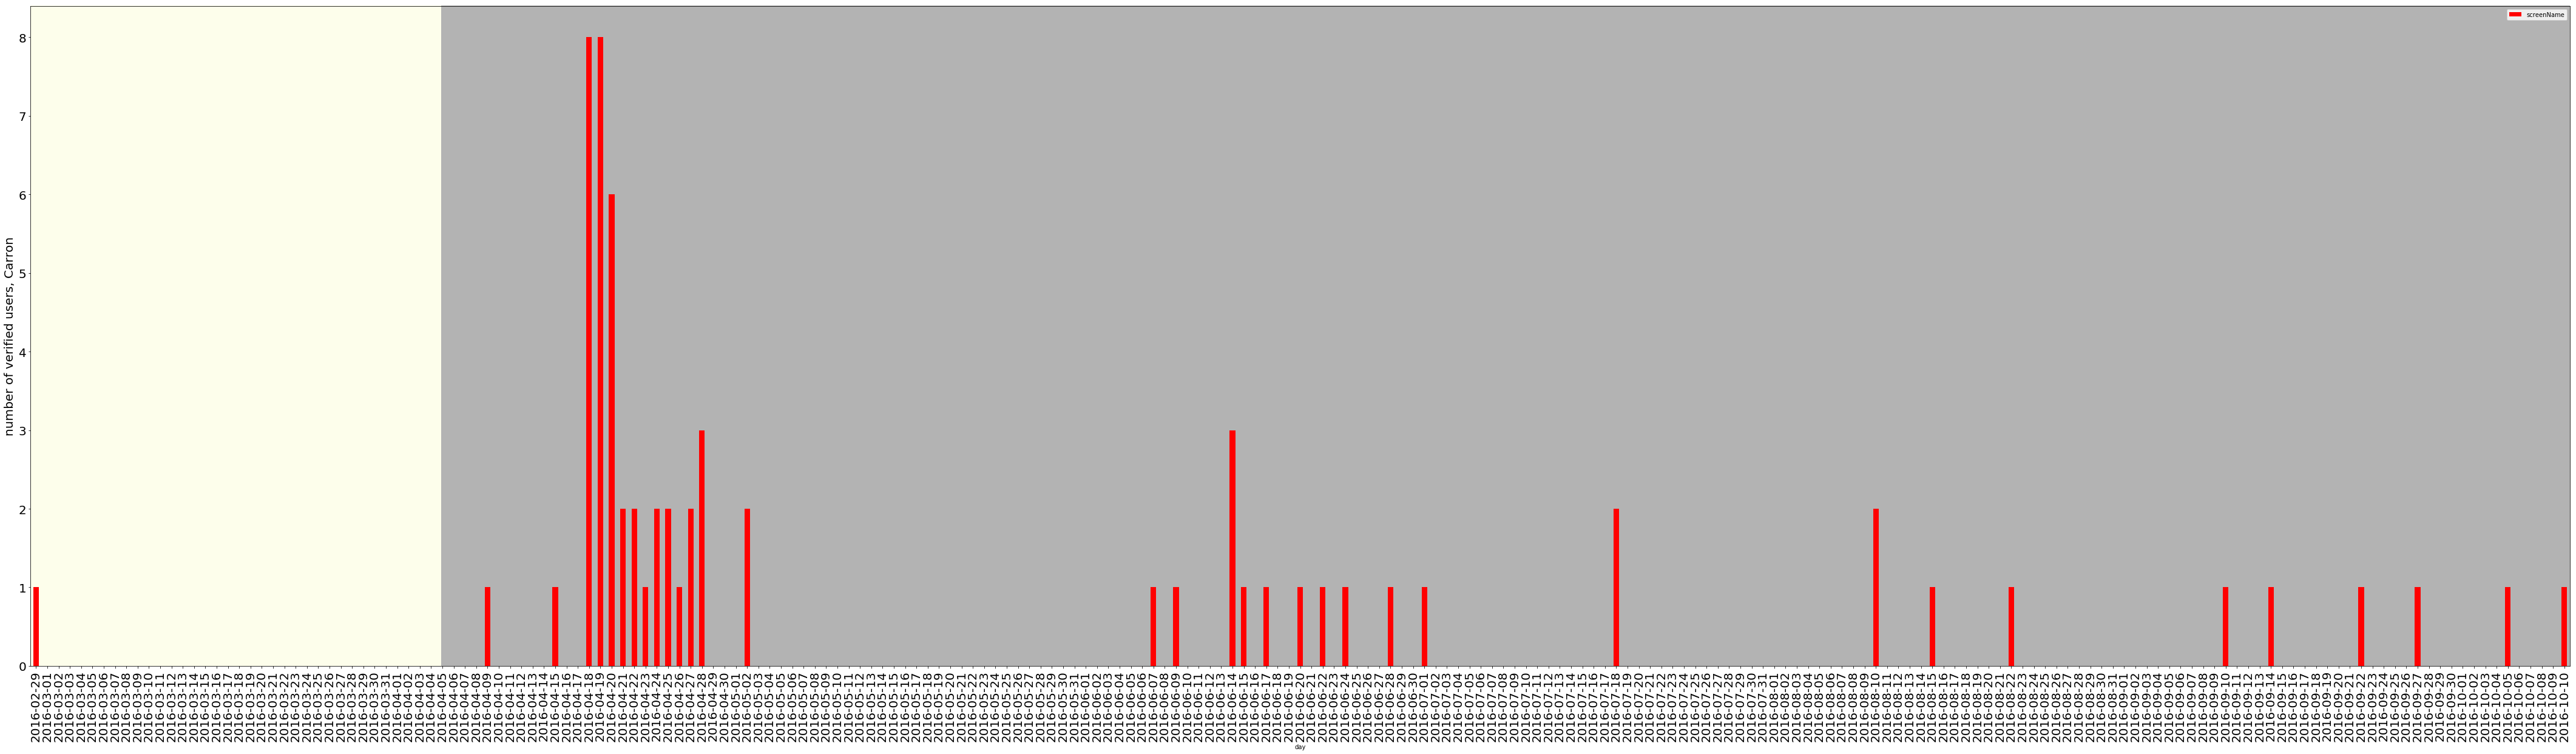

In [28]:
descr_user_ver("Carron", "2016-04-18")

In [29]:
noisy_pos_tags = ["PROP","DET","PART","CCONJ","ADP","PRON"]
def is_noise(token):
    '''
    standard way to validate spacy tokens
    This method validate all the passed tokens and set true false on it
    '''
    is_noise = False
    if token.pos_ in noisy_pos_tags:
        is_noise = True 
    elif token.is_stop == True:
        is_noise = True
    elif token.is_digit == True:
        is_noise = True
    elif token.is_punct == True:
        is_noise = True
    elif token.is_space == True:
        is_noise = True
    elif len(token.string) <= 4:
        is_noise = True
    return is_noise

In [45]:
def frequency(name, df):
    tweet = []
    for index, row in df[df['firmName'] == name].iterrows():
        words = row['cleaned_text']
        words = str(words)
        #words = remove_specific_stop(words)
        nlp_words = nlp(words)
        for word in nlp_words:
            if not is_noise(word):
                tweet.append(word.lemma_)
    return tweet

In [32]:
import nltk
def most_frequent_words (tweet):
    
    """function to search for 15 top frequent words"""
    
    freq_dist = nltk.FreqDist(tweet)
    most_frequent_words=nltk.FreqDist(tweet).most_common(15)
    print (freq_dist.plot(15))
    plt.tight_layout()
    plt.savefig('most_frequent_words.jpg')

In [33]:
def most_frequent_hashtags(name, df=df1):
    
    """function to search for 15 top frequent hashtags"""
    
    df = df[df['firmName'] == name]
    df.dropna(inplace = True)
    freq_dist = nltk.FreqDist(df.hashtags)
    most_frequent_words=nltk.FreqDist(df.hashtags).most_common(15)
    print (freq_dist.plot(15, color = 'r'))
    plt.tight_layout()
    plt.savefig('most_frequent_words.jpg')

In [57]:
def sent_plot_ver(name):
    dfi = df2[df2['firmName'] == name]
    ax = dfi.groupby(dfi['date'])["Sentiment_score"].mean().plot(kind='line', figsize = (30, 10), title=name,
                                                                         grid = True, fontsize=20, color = "g") 
    ax.set_ylabel("mean polarity score, " + name, fontsize=20)
    plt.xticks(rotation='horizontal')

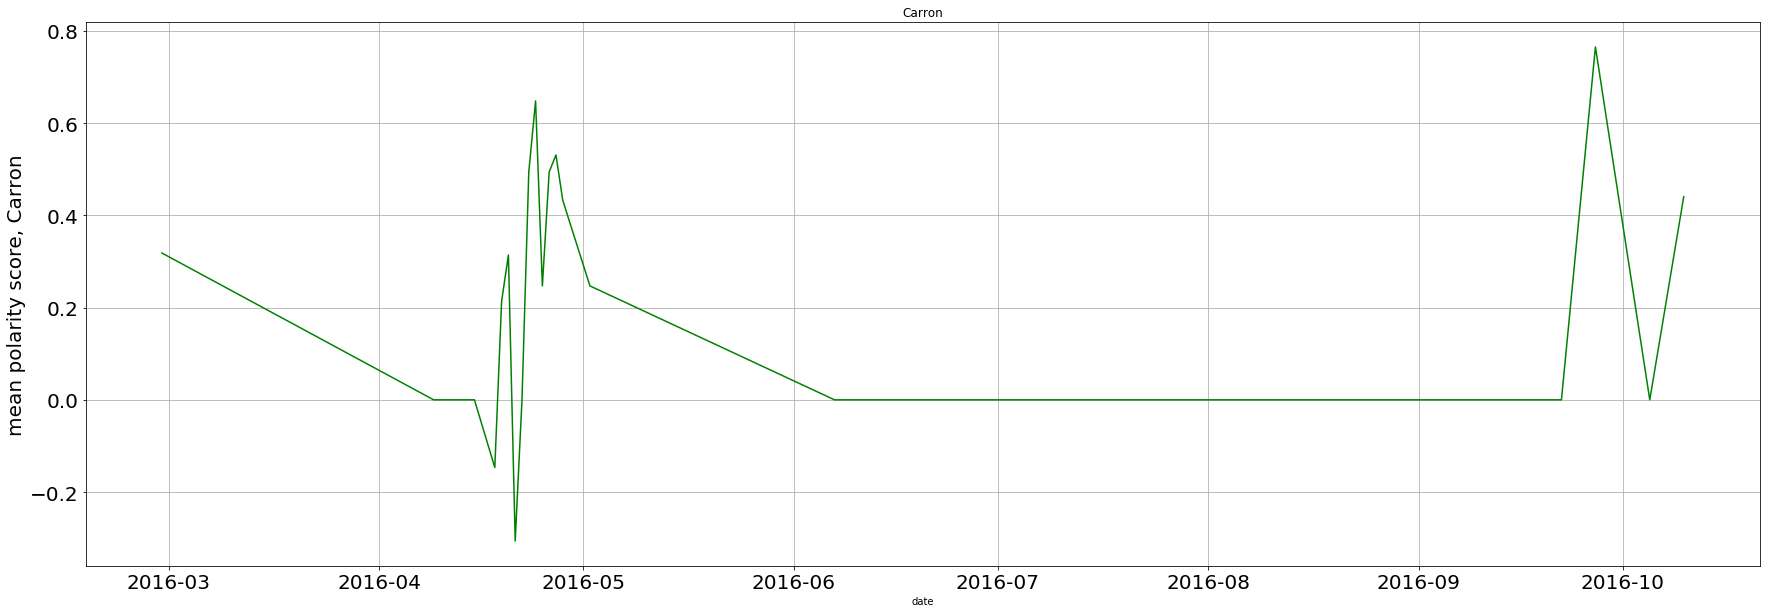

In [58]:
sent_plot("Carron")

In [34]:
startdate = "2016-04-18" #the date of announcement
enddate = "2016-04-27"#a week after announcement

In [35]:
start = pd.to_datetime(startdate).date()
end = pd.to_datetime(enddate).date()
mask = (df['date'] > start) & (df['date'] <= end)

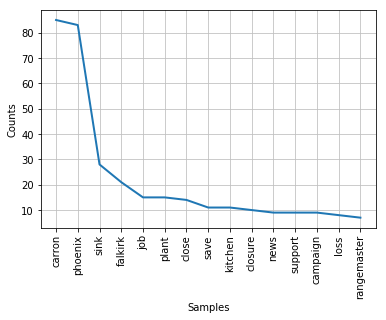

None


<Figure size 432x288 with 0 Axes>

In [48]:
most_frequent_words(frequency("Carron", df))

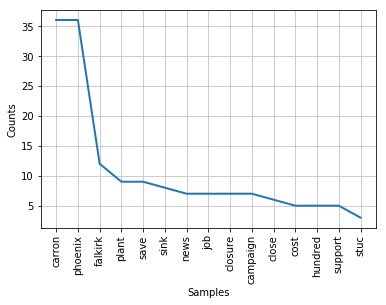

None


<Figure size 432x288 with 0 Axes>

In [49]:
most_frequent_words(frequency("Carron", df = df.loc[mask]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


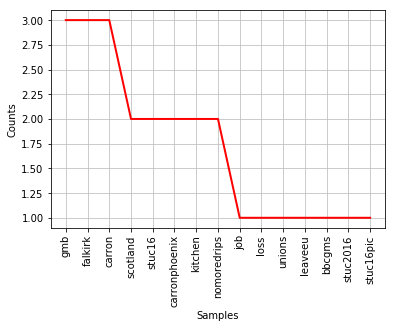

None


<Figure size 432x288 with 0 Axes>

In [50]:
most_frequent_hashtags("Carron", df= df1)